# Monte Carlo Simulation Number 1    

The following is a first attempt at Python/Spyder/JupyterLab, so please forgive the awkward code (and please provide improvements)! The first section draws from an excel file using pandas, with the following considerations:  
1. sheet 0 gives global data for discount rates, etc.  
2. Sheet 1 gives data for the base case 2015 PV values, using values from Rebecca Jones-Albertus, et al, Progress in Photovoltaics: Research and Applications, 2016, DOI: 10.1002/pip.2755, for the residential case. Note that values in columns a, b, c are slight deltas from the base case value so that the python triangular distribution does not have problems.  
3. Sheets 2, 3, and 4 give made-up values for experts A, B, and C, respectiely. The spreadsheet also has a cell for weighting the expert estimate, for which the number of iterations used for that expert is proportionately changed. The values listed were chosen to distinctly show that expert C projects much less reduction in LCOE than the other experts, and that expert's estimate is weighted at a lower value. This approach can be generalized to the input from any number of experts.  

The values from the spreadsheet are put into python triangular distributions to generate Monte Carlo distributions of the LCOE for the base case and for each of the experts' estimates, and this is shown in the graph of the distributions.

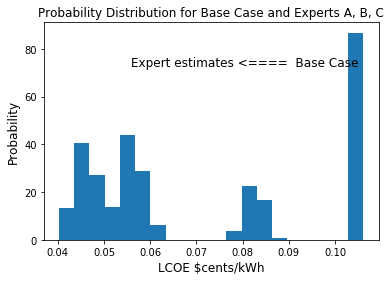

In [1]:
import math
import random
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

xlsxFile = pd.ExcelFile('Q:/AASamBaldwinActive2020/ZSam2020/AAonTheRoadSam/PythonModeling/BaldwinRDPathwaysToyModel1.xlsx')  # How do I move an excel file into JupyterLab?

def GLOBAL(h):
    df = xlsxFile.parse(h)  
    DR = df.iat[3,2]                                                                  #Discount Rate
    SDR = df.iat[4,2]                                                                 #Social Discount Rate
    INS = df.iat[5,2]                                                                 #Insolation
    return(DR, SDR, INS)
(DR, SDR, INS) = GLOBAL(0)
#print(DR, SDR, INS)                                                                  #Placeholder print command

def LCOE1(i, j, k):
    dg = xlsxFile.parse(i)
    SSZ = dg.iat[j+2, k+1]
    
    MCC = random.triangular(dg.iat[j+3,k+2], dg.iat[j+3,k+4], dg.iat[j+3, k+3])        #Module Capital Cost in $/m2
    MLT = random.triangular(dg.iat[j+4,k+2], dg.iat[j+4,k+4], dg.iat[j+4, k+3])        #Module Lifetime in Years
    MEF = random.triangular(dg.iat[j+5,k+2], dg.iat[j+5,k+4], dg.iat[j+5, k+3])        #Module Efficiency in %/100
    MAP = random.triangular(dg.iat[j+6,k+2], dg.iat[j+6,k+4], dg.iat[j+6, k+3])        #Module Aperture in %/100 as fraction of system size
    MOM = random.triangular(dg.iat[j+7,k+2], dg.iat[j+7,k+4], dg.iat[j+7, k+3])        #Module O&M Fixed in $/kWyear
    MDR = random.triangular(dg.iat[j+8,k+2], dg.iat[j+8,k+4], dg.iat[j+8, k+1])        #Module Degradation Rate in %/100
    MCF = random.triangular(dg.iat[j+9,k+2], dg.iat[j+9,k+4], dg.iat[j+9, k+3])        #Module Capacity Factor for the location in %/100
    MSL = random.triangular(dg.iat[j+10,k+2], dg.iat[j+10,k+4], dg.iat[j+10, k+3])     #Module Soiling Loss in %/100
    ICC = random.triangular(dg.iat[j+11,k+2], dg.iat[j+11,k+4], dg.iat[j+11, k+3])     #Inverter Capital Cost in $/W
    ILT = random.triangular(dg.iat[j+12,k+2], dg.iat[j+12,k+4], dg.iat[j+12, k+3])     #Inverter Lifetime in years
    IRC = random.triangular(dg.iat[j+13,k+2], dg.iat[j+13,k+4], dg.iat[j+13, k+3])     #Inverter Replacement Cost in %/100 of new system
    IEF = random.triangular(dg.iat[j+14,k+2], dg.iat[j+14,k+4], dg.iat[j+14, k+3])     #Inverter Efficiency in %/100
#    IDC = random.triangular(dg.iat[15,k], dg.iat[15,k+2], dg.iat[15,k+3])             #Inverter DC-to-AC Power Ratio; not used at present
    BCC = random.triangular(dg.iat[j+16,k+2], dg.iat[j+16,k+4], dg.iat[j+16, k+3])     #Balance-of-System Hardware Capital Cost in $/m2
    BLR = random.triangular(dg.iat[j+17,k+2], dg.iat[j+17,k+4], dg.iat[j+17, k+3])     #BOS Labor Cost for system installation
    BPR = random.triangular(dg.iat[j+18,k+2], dg.iat[j+18,k+4], dg.iat[j+18, k+3])     #BOS Permitting Cost for system
    BCA = random.triangular(dg.iat[j+19,k+2], dg.iat[j+19,k+4], dg.iat[j+19, k+3])     #BOS Customer Acquisition Cost in $ per system
    BOH = random.triangular(dg.iat[j+20,k+2], dg.iat[j+20,k+4], dg.iat[j+20, k+3])     #BOS Overhead and profit for installer in %/100

    SMCXA = SSZ * MCC                                                                  #System Module Capital Cost
    SICXA = INS * SSZ * MEF * ICC                                                      #System Inverter Capital Cost
    if MLT > ILT and MLT < 2*ILT:                
        RSICXA = (SICXA*IRC*(1/(1+DR)**ILT) - 
        SICXA*IRC*((2*ILT - MLT)/ILT*(1/(1+DR))**MLT))
        SICXA = SICXA + RSICXA                                                        #System Inverter Capital Cost with one Replacement
    if MLT > 2*ILT and MLT < 3*ILT:                
        RSICXA = (SICXA*IRC*(1/(1+DR)**ILT) +
        SICXA*IRC*(1/(1+DR)**(2*ILT)) -
        SICXA*IRC*((3*ILT - MLT)/ILT)*(1/(1+DR))**MLT)
        SICXA = SICXA + RSICXA                                                        #System Inverter Capital Cost with two Replacements
    SBH = BCC*SSZ                                                                     #System BOS Hardware Cost
    SBS = BLR + BPR + BCA                                                             #System BOS Softcost for Labor, Permitting, Customers
    SOH = BOH*(SMCXA + SICXA + SBH + SBS)                                             #System Overhead Costs
    STC = SMCXA + SICXA + SBH + SBS + SOH                                             #Total System Installed Cost

    SEA = ((INS/1000)*24*365*SSZ*MAP*MCF*MEF*IEF*
              (1-MSL)*(1-(1-MDR)**(MLT+1))/(1-(1-MDR)))                               #System Lifetime Energy Conversion
    SOM = MOM*(INS/1000)*SSZ*MEF*(1-(1/(1+DR))**(MLT+1))/(1-(1/(1+DR)))               #System Lifetime Overhead Cost
    LCOEadvance = (STC + SOM)/SEA 
    return(LCOEadvance)

LCOEbase = []
LCOEadvanceA = []
LCOEadvanceB = []
LCOEadvanceC = []

iterations = 500                                                                    #Iterations are weighted for each expert off spreadsheet to show relative value
for m in range(iterations):
    LCOEbase.append(LCOE1(1, 0, 2))
dgA=xlsxFile.parse(2)
ExpertWeightA = dgA.iat[21, 3]
for m in range(int(ExpertWeightA*iterations)):
    LCOEadvanceA.append(LCOE1(2, 0, 2))
dgB=xlsxFile.parse(3)
ExpertWeightB = dgB.iat[21, 3]
for m in range(int(ExpertWeightB*iterations)):
    LCOEadvanceB.append(LCOE1(3, 0, 2))
dgC=xlsxFile.parse(4)
ExpertWeightC = dgC.iat[21, 3]
for m in range(int(ExpertWeightC*iterations)):
    LCOEadvanceC.append(LCOE1(4, 0, 2))
LCOE = LCOEbase + LCOEadvanceA + LCOEadvanceB + LCOEadvanceC

fig, ax = plt.subplots()
pylab.hist(LCOE, bins=20, density=True)
pylab.title('Probability Distribution for Base Case and Experts A, B, C')
pylab.xlabel('LCOE $cents/kWh', fontsize=12.)
pylab.ylabel('Probability', fontsize=12.)
ax.annotate('Expert estimates <====  Base Case', xy=(0.6,0.8), fontsize=12, xycoords='axes fraction', ha='center')
pylab.show()


## Tornado Diagram for Practical Potential  

This compares the potential improvement estimates for Expert A to the base case and then rank prioritizes these values in a tornado chart.

Potential future improvements include:  
1. Showing the ranking as reductions in cost rather than positive improvements;


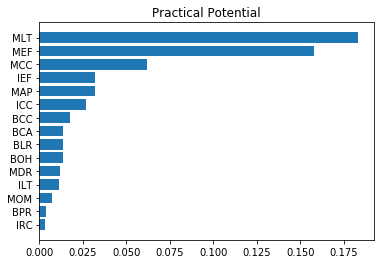

In [2]:
LCOEbaseAve  = sum(LCOEbase)/iterations
#  print(LCOEbaseAve)
#  print('{:05.4f}'.format(LCOEbaseAve))


def GLOBAL(h):
    df = xlsxFile.parse(h)  
    DR = df.iat[3,2]                                
    SDR = df.iat[4,2]                               
    INS = df.iat[5,2]                               
    return(DR, SDR, INS)
(DR, SDR, INS) = GLOBAL(0)

def LCOE1(i, j, k, l):
    dg = xlsxFile.parse(i)
    dgdelta = xlsxFile.parse(2) 
    SSZ = dg.iat[j+2, k+1]
    
    MCC = dg.iat[j+3, k+3]        #Module Capital Cost in $/m2
    if l == 3: MCC = dgdelta.iat[j+3, k+3]
    MLT = dg.iat[j+4, k+3]        #Module Lifetime in Years
    if l == 4: MLT = dgdelta.iat[j+4, k+3]
    MEF = dg.iat[j+5, k+3]        #Module Efficiency in %/100
    if l == 5: MEF = dgdelta.iat[j+5, k+3]
    MAP = dg.iat[j+6, k+3]        #Module Aperture in %/100 as fraction of system size
    if l == 6: MAP = dgdelta.iat[j+6, k+3]
    MOM = dg.iat[j+7, k+3]        #Module O&M Fixed in $/kWyear
    if l == 7: MOM = dgdelta.iat[j+7, k+3]
    MDR = dg.iat[j+8, k+3]        #Module Degradation Rate in %/100
    if l == 8: MDR = dgdelta.iat[j+8, k+3]
    MCF = dg.iat[j+9, k+3]        #Module Capacity Factor for the location in %/100
    if l == 9: MCF = dgdelta.iat[j+9, k+3]
    MSL = 0  #dg.iat[j+10, k+3]        #Module Soiling Loss in %/100
#    if l == 10: MSL = dgdelta.iat[j+10, k+3]
    ICC = dg.iat[j+11, k+3]     #Inverter Capital Cost in $/W
    if l == 11: ICC = dgdelta.iat[j+11, k+3]
    ILT = dg.iat[j+12, k+3]     #Inverter Lifetime in years
    if l == 12: ILT = dgdelta.iat[j+12, k+3]
    IRC = dg.iat[j+13, k+3]     #Inverter Replacement Cost in %/100 of new system
    if l == 13: IRC = dgdelta.iat[j+13, k+3]
    IEF = dg.iat[j+14, k+3]     #Inverter Efficiency in %/100
    if l == 14: IEF = dgdelta.iat[j+14, k+3]
#    IDC =                                                                      #Inverter DC-to-AC Power Ratio
    BCC = dg.iat[j+16, k+3]     #Balance-of-System Hardware Capital Cost in $/m2
    if l == 16: BCC = dgdelta.iat[j+16, k+3]
    BLR = dg.iat[j+17, k+3]     #BOS Labor Cost for system installation
    if l == 17: BLR = dgdelta.iat[j+17, k+3]
    BPR = dg.iat[j+18, k+3]     #BOS Permitting Cost for system
    if l == 18: BPR = dgdelta.iat[j+18, k+3]
    BCA = dg.iat[j+19, k+3]     #BOS Customer Acquisition Cost in $ per system
    if l == 19: BCA = dgdelta.iat[j+19, k+3]
    BOH = dg.iat[j+20, k+3]     #BOS Overhead and profit for installer in %/100
    if l == 20: BOH = dgdelta.iat[j+20, k+3]

    SMCXA = SSZ * MCC                                                          #System Module Capital Cost
    SICXA = INS * SSZ * MEF * ICC                                              #System Inverter Capital Cost
    if MLT > ILT and MLT < 2*ILT:                
        RSICXA = (SICXA*IRC*(1/(1+DR)**ILT) - 
        SICXA*IRC*((2*ILT - MLT)/ILT*(1/(1+DR))**MLT))
        SICXA = SICXA + RSICXA                                                 #System Inverter Capital Cost with one Replacement
    if MLT > 2*ILT and MLT < 3*ILT:                
        RSICXA = (SICXA*IRC*(1/(1+DR)**ILT) +
        SICXA*IRC*(1/(1+DR)**(2*ILT)) -
        SICXA*IRC*((3*ILT - MLT)/ILT)*(1/(1+DR))**MLT)
        SICXA = SICXA + RSICXA                                                 #System Inverter Capital Cost with two Replacements
    SBH = BCC*SSZ                                                              #System BOS Hardware Cost
    SBS = BLR + BPR + BCA                                                      #System BOS Softcost for Labor, Permitting, Customers
    SOH = BOH*(SMCXA + SICXA + SBH + SBS)                                      #System Overhead Costs
    STC = SMCXA + SICXA + SBH + SBS + SOH                                      #Total System Installed Cost

    SEA = ((INS/1000)*24*365*SSZ*MAP*MCF*MEF*IEF*
              (1-MSL)*(1-(1-MDR)**(MLT+1))/(1-(1-MDR)))                        #System Lifetime Energy Conversion
    SOM = MOM*(INS/1000)*SSZ*MEF*(1-(1/(1+DR))**(MLT+1))/(1-(1/(1+DR)))        #System Lifetime Overhead Cost
    LCOEadvance = (STC + SOM)/SEA 
    return(LCOEadvance)
    
LCOEbase = LCOE1(1, 0, 2, 0)
MCC = (LCOEbase - LCOE1(1, 0, 2, 3))/LCOEbase
MLT = (LCOEbase - LCOE1(1, 0, 2, 4))/LCOEbase
MEF = (LCOEbase - LCOE1(1, 0, 2, 5))/LCOEbase
MAP = (LCOEbase - LCOE1(1, 0, 2, 6))/LCOEbase
MOM = (LCOEbase - LCOE1(1, 0, 2, 7))/LCOEbase
MDR = (LCOEbase - LCOE1(1, 0, 2, 8))/LCOEbase
#MCF = (LCOEbase - LCOE1(1, 0, 2, 9))/LCOEbase
#MSL = (LCOEbase - LCOE1(1, 0, 2, 10))/LCOEbase

ICC = (LCOEbase - LCOE1(1, 0, 2, 11))/LCOEbase
ILT = (LCOEbase - LCOE1(1, 0, 2, 12))/LCOEbase
IRC = (LCOEbase - LCOE1(1, 0, 2, 13))/LCOEbase
IEF = (LCOEbase - LCOE1(1, 0, 2, 14))/LCOEbase
#IDC = (LCOEbase - LCOE1(1, 0, 2, 15))/LCOEbase

BCC = (LCOEbase - LCOE1(1, 0, 2, 16))/LCOEbase
BLR = (LCOEbase - LCOE1(1, 0, 2, 17))/LCOEbase
BPR = (LCOEbase - LCOE1(1, 0, 2, 18))/LCOEbase
BCA = (LCOEbase - LCOE1(1, 0, 2, 19))/LCOEbase
BOH = (LCOEbase - LCOE1(1, 0, 2, 20))/LCOEbase

height = (MCC, MLT, MEF, MAP, MOM, MDR, ICC, ILT,
           IRC, IEF, BCC, BLR, BPR, BCA, BOH)
tornado = ('MCC', 'MLT', 'MEF', 'MAP', 'MOM', 'MDR', 'ICC', 'ILT',
           'IRC', 'IEF', 'BCC', 'BLR', 'BPR', 'BCA', 'BOH')
tornado1 = {'MCC':MCC, 'MLT':MLT, 'MEF':MEF, 'MAP':MAP, 'MOM':MOM, 'MDR':MDR, 'ICC':ICC, 'ILT':ILT,
           'IRC':IRC, 'IEF':IEF, 'BCC':BCC, 'BLR':BLR, 'BPR':BPR, 'BCA':BCA, 'BOH':BOH}
#tornado1 = zip(tornado, height)                                                  How can I make Zip work on this?

tornadoTuples = sorted(tornado1.items(), key=lambda x: x[1])

title, bar = zip(*tornadoTuples)

y_pos = np.arange(len(title))
plt.barh(y_pos, bar)
plt.yticks(y_pos, title)
plt.title('Practical Potential')
plt.show()


## Tornado Diagram for Cost Effective Potential  

Ths takes the expert estimated improvements compared to the base case that were generated above and renormalizes them by the same expert's estimates of the mean cost to make those improvements, and then rank prioritizes these values in a tornado diagram.  

Potential future improvements include:  
1. Showing the ranking as reductions in cost rather than positive improvements;
2. Using the expert estimated distribution of R&D investment and distribution of LCOE cost reductions to generate a tornado diagram with a distribution.



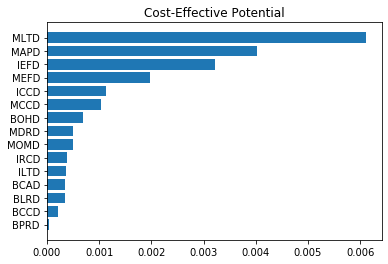

In [3]:
dgdelta = xlsxFile.parse(2) 
j = 0
k = 2
MCCD = MCC / dgdelta.iat[j+3, k+6]
MLTD = MLT / dgdelta.iat[j+4, k+6]
MEFD = MEF / dgdelta.iat[j+5, k+6]
MAPD = MAP / dgdelta.iat[j+6, k+6]
MOMD = MOM / dgdelta.iat[j+7, k+6]
MDRD = MDR / dgdelta.iat[j+8, k+6]
ICCD = ICC / dgdelta.iat[j+11, k+6]
ILTD = ILT / dgdelta.iat[j+12, k+6]
IRCD = IRC / dgdelta.iat[j+13, k+6]
IEFD = IEF / dgdelta.iat[j+14, k+6]
BCCD = BCC / dgdelta.iat[j+16, k+6]
BLRD = BLR / dgdelta.iat[j+17, k+6]
BPRD = BPR / dgdelta.iat[j+18, k+6]
BCAD = BCA / dgdelta.iat[j+19, k+6]
BOHD = BOH / dgdelta.iat[j+20, k+6]

height = (MCCD, MLTD, MEFD, MAPD, MOMD, MDRD, ICCD, ILTD,
           IRCD, IEFD, BCCD, BLRD, BPRD, BCAD, BOHD)
tornado = ('MCCD', 'MLTD', 'MEFD', 'MAPD', 'MOMD', 'MDRD', 'ICCD', 'ILTD',
           'IRCD', 'IEFD', 'BCCD', 'BLRD', 'BPRD', 'BCAD', 'BOHD')
tornadoD = {'MCCD':MCCD, 'MLTD':MLTD, 'MEFD':MEFD, 'MAPD':MAPD, 'MOMD':MOMD, 'MDRD':MDRD, 'ICCD':ICCD, 'ILTD':ILTD,
           'IRCD':IRCD, 'IEFD':IEFD, 'BCCD':BCCD, 'BLRD':BLRD, 'BPRD':BPRD, 'BCAD':BCAD, 'BOHD':BOHD}

tornadoTuplesD = sorted(tornadoD.items(), key=lambda x: x[1])

title, bar = zip(*tornadoTuplesD)

y_pos = np.arange(len(title))
plt.barh(y_pos, bar)
plt.yticks(y_pos, title)
plt.title('Cost-Effective Potential')
plt.show()


## WaterFall Chart  

The following generates a waterfall chart from the cost-effective potential outputs:  
